In [3]:
%matplotlib inline
from IPython.display import clear_output
import time
from Environments.environments import all_envs, get_all_avail_envs
from Agents.dqn_agent import DQN_Agent
from Agents.ppo_agent import PPO_Agent
from Models import fc, rnn
import matplotlib.pyplot as plt
import torch
import utils
from Curriculum_managers.random_curriculum import Random_Curriculum
from Curriculum_managers.paired_curriculum import PAIRED_Curriculum
from Curriculum_managers.paired_curriculum_extented import  PAIRED_Curriculum_entropy
from Curriculum_managers.paired_curriculum_extented_no_regret import  PAIRED_Curriculum_no_regret_entropy
import plotly.express as px
import gym
import os
# os.environ["LANG"]="en_US"

In [4]:
env_names = get_all_avail_envs()
env_names

['SingleTaxiEnv',
 'FrozenLakeEnv',
 'AdversarialEnv',
 'ReparameterizedAdversarialEnv',
 'MiniAdversarialEnv',
 'MiniReparameterizedAdversarialEnv',
 'NoisyAdversarialEnv',
 'MediumAdversarialEnv',
 'GoalLastAdversarialEnv',
 'MiniGoalLastAdversarialEnv']

In [5]:
device = utils.init_torch()

In [7]:
env = all_envs['MiniAdversarialEnv'](random_reset_loc=False)
n_actions = env.action_space.n
obs_shape = env.observation_space.shape
gen_obs_shape = env.get_generator_observation_space().shape
gen_action_dim = env.get_generator_action_space().n
# gen_obs_shape = env.get_generator_observation_space()


In [5]:
# env = gym.envs.make("CartPole-v1")
# n_actions = env.action_space.n
# obs_shape = env.observation_space.shape

### Random curriculum train single example:

In [9]:
# agent = PPO(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.3, eps_dec=0, lr=0.001, model=rnn.RNN)
# teacher_agent = DQN_Agent(gen_obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.3, eps_dec=0, lr=0.001, model=rnn.RNN)

r_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)


In [10]:
r_teacher = Random_Curriculum(env, trainee=r_agent)

In [11]:
r_rewards = r_teacher.teach(n_iters=5000, n_episodes=8)

R:000000.0:   5%|▌         | 260/5000 [04:03<1:21:26,  1.03s/it]

# PAIRED CURRICULUM

In [10]:
p_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
p_teacher = PAIRED_Curriculum(env, teacher_agent=teacher_agent ,trainee=p_agent)
p_rewards = p_teacher.teach(n_iters=5000, n_episodes=8)

In [ ]:
# fig = px.line(x=range(len(p_rewards)), y=p_rewards, title='Train rewards')
# fig.show()

# PARIED_ENTROPY

In [9]:
p_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
p_teacher = PAIRED_Curriculum_entropy(env, teacher_agent=teacher_agent ,trainee=p_agent)
p_rewards = p_teacher.teach(n_iters=5000, n_episodes=8)

  0%|          | 0/5000 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

# PARIED_ENTROPY_NO_REGRET

In [8]:
p_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
p_teacher = PAIRED_Curriculum_no_regret_entropy(env, teacher_agent=teacher_agent ,trainee=p_agent)
p_rewards = p_teacher.teach(n_iters=5000, n_episodes=8)

  0%|          | 0/5000 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

# RESULTS CHECK

In [54]:
agent = r_agent

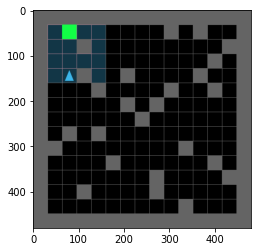

[4] 0 False


KeyboardInterrupt: 

In [60]:
agent.set_train_mode()
for i in range(1):
    obs = env.reset()
    # break
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        clear_output(wait=True)
        plt.imshow(env.render('rgb_array'))
        plt.show()
        # env.render(mode='rgb_array')
        # env.render()
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        print(action, r, done)

        R += r
        t += 1
        reset = t == 500
        time.sleep(0.5)
        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)